This work is done after the review received on the day of presentation. This program uses both - context polarity attribute of the proposed algorithm and feature vector of the Term Frequency - Inverse Document Frequency algorithm to train models as suggested.

In [9]:
#dataset reading
import pandas as pd
csv=pd.read_csv("spam.csv", encoding='Windows-1252')
csv=csv.sample(frac=1)
csv.reset_index(inplace=True)
data=csv[0:5573]

print(data.loc[0, 'v1'])

# Replace 'ham' with 1 and 'spam' with 0
data['v1'] = data['v1'].replace({'ham': 1, 'spam': 0})

print(data.loc[0, 'v1'])


ham
1


In [10]:
#creating a new column for prediction scores and initializing as null
import numpy as np
data['review_score'] = np.nan

        

In [11]:
#importing nltk and downloading important packages
import nltk
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords', quiet=True)
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
list(swn.senti_synsets('slow'))
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#function for converting tags to WorldNet standard
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

#function to predict polarity score of a sentence
def pred_score(sentence):

    #number of negation words
    neg_num=0

    #return null if sentence is empty
    if(len(sentence.split())==0):
        return np.nan

    #List of negating words
    negation_words = [
    "no", "not", "rather", "couldnt", "wasnt", "didnt", "wouldnt",
    "shouldnt", "werent", "dont", "doesnt", "havent", "hasnt", "wont",
    "wont", "hadnt", "never", "none", "nobody", "nothing", "neither", "nor",
    "nowhere", "isnt", "cant", "cannot", "mustnt", "mightnt", "shant",
    "without", "neednt", "hardly", "less", "little", "rarely", "scarcely",
    "seldom", "nt"
    ]
    
    #reading spam and ham word lists
    negative_file = 'spam.txt'
    positive_file ='ham.txt'
    CleanSentence=""
    sentiment=0

    #Removing single and double quotes from the sentence
    for i in sentence:
        if i == '"':
                CleanSentence=CleanSentence+" "
        elif i!="'":
                CleanSentence=CleanSentence+i
    
    #Punctuation Removal
    import string
    translator = str.maketrans('', '', string.punctuation)
    CleanSentence_noPunc=CleanSentence.translate(translator)
    
    #token creation and Stopwords Removal
    stop_words = set(stopwords.words('english'))
    token_unfiltered = nltk.word_tokenize(CleanSentence)
    token=[word for word in token_unfiltered if word.lower() not in stop_words]

    #return 0 if sentence only has stopwords
    if(len(token)==0):
        return 0

    #POS Tagging of tokens
    from nltk.tag import pos_tag
    after_tagging = nltk.pos_tag(token)
    negate=0

    #polarity value prediction
    for i in range(len(after_tagging)):
                flag=0

                #Only selecting adverbs, nouns, verbs and adjectives
                if after_tagging[i][1].startswith('J') or after_tagging[i][1].startswith('N') or after_tagging[i][1].startswith('R') or after_tagging[i][1].startswith('V'):

                    #skipping if a negation word is found
                    if after_tagging[i][0] in negation_words:
                        neg_num=neg_num+1
                        continue
                    elif (
                        #sliding window of size 5
                        i + 2 < len(after_tagging) and after_tagging[i + 2][0] in negation_words or
                        i - 1 >= 0 and after_tagging[i - 1][0] in negation_words or
                        i - 2 >= 0 and after_tagging[i - 2][0] in negation_words or
                        i + 1 < len(after_tagging) and after_tagging[i + 1][0] in negation_words
                        ):
                        negate=1
                    else:
                        negate=0
                    
                    #opening negative words list file
                    with open(positive_file,'r') as file:
                        for line in file:
                                if line.strip()==after_tagging[i][0]:
                                        if negate==1:
                                                sentiment=sentiment-1 #giving 1 score if negation
                                        else:
                                                sentiment=sentiment+1 #giving -1 score if no negation
                                        flag=1       
                                        break 
                        if flag==1:
                                continue   

                    #opening positive words list file            
                    with open(negative_file,'r') as file:
                        for line in file:
                                if line.strip()==after_tagging[i][0]:
                                        if negate==1: 
                                                sentiment=sentiment+1 #giving -1 score if negation
                                        else:
                                                sentiment=sentiment-1 #giving 1 score if no negation
                                        flag=1
                                        break
                        if flag==1:
                                continue 

                    #tag conversion to WordNets standard               
                    wn_tag = penn_to_wn(after_tagging[i][1])  

                    #Lemmatization
                    lemma = lemmatizer.lemmatize(after_tagging[i][0], pos=wn_tag)
                    if not lemma:
                        continue
                    
                    #Finding sense of word from WordNets if word not found in both the lists
                    synsets = wn.synsets(lemma, pos=wn_tag)
                    if not synsets:
                        continue
                    
                    #Taking  the first sense recieved
                    synset = synsets[0]

                    #opening negative words list file
                    with open(positive_file,'r') as file:
                        for line in file:
                                if line.strip()==synset.name():
                                        if negate==1:
                                                sentiment=sentiment-1 #giving 1 score if negation
                                        else:
                                                sentiment=sentiment+1 #giving -1 score if no negation
                                        flag=1       
                                        break 
                        if flag==1:
                                continue  

                    #opening positive words list file            
                    with open(negative_file,'r') as file:
                        for line in file:
                                if line.strip()==synset.name():
                                        if negate==1: 
                                                sentiment=sentiment+1 #giving -1 score if negation
                                        else:
                                                sentiment=sentiment-1 #giving 1 score if no negation
                                        flag=1
                                        break
                        if flag==1:
                                continue  

    return sentiment/(len(token)-neg_num) #returning score aggregate

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\shaur\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shaur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shaur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\shaur\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
#Finding polarity scores for all messages and assigning them to the newly added columns
for i in range(len(data)):
    if not pd.isnull(data.iloc[i]['v2']):
        data.loc[i,['review_score']]=pred_score(data.iloc[i]['v2'])
        



In [13]:
#copying dataframe
data1=data.copy(deep=True)

#Null Values Handling
mean_value = data1['review_score'].mean()
data1['review_score'].fillna(value=mean_value, inplace=True)

In [14]:
data1['score']=data1['review_score']

In [15]:
#extracting feature vector from the data using TF-IDF algorithm
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.sparse import hstack

score = data1['score'].values[:,None]

#Training Data Scaling
from sklearn.preprocessing import StandardScaler

ScalingObj=StandardScaler()
ScalingObj.fit(score)
features=ScalingObj.transform(score)
score=pd.DataFrame(features)

X = data1['v2']
y = data1['v1']

# Remove punctuation and stopwords
stop_words = set(stopwords.words('english'))
X = X.apply(lambda x: ''.join(ch for ch in x if ch not in string.punctuation))
X = X.apply(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stop_words))

# Convert text data into bag-of-words format
vectorizer_TFIDF = TfidfVectorizer()

#combining polarity scores and TF-IDF feature vector
X_tfidf = hstack([vectorizer_TFIDF.fit_transform(X),score])

c:\Users\shaur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\shaur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy for the classifier using Logistic Regression =  0.9413875598086124
F1-Score for the classifier using Logistic Regression =  0.966824644549763

Accuracy for the classifier using Multi-Layered Perceptron Neural Network =  0.9766746411483254
F1-Score for the classifier using Multi-Layered Perceptron Neural Network =  0.9865191842378155
Precision for the classifier using Multi-Layered Perceptron Neural Network =  0.9747267759562842
Recall for the classifier using Multi-Layered Perceptron Neural Network =  0.9986004198740378
ROC-AUC score for the classifier using Multi-Layered Perceptron Neural Network =  0.9231685226942207
LOG-LOSS score for the classifier using Multi-Layered Perceptron Neural Network =  0.8407311496265366
Confusion Matrix for the classifier using Multi-Layered Perceptron Neural Network : 


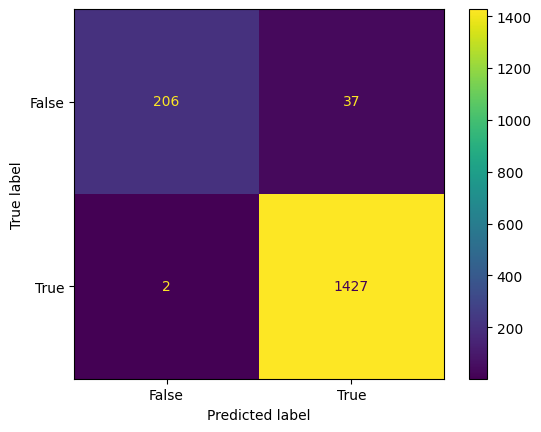


Accuracy for the classifier using Naive Bayes =  0.9049043062200957
F1-Score for the classifier using Naive Bayes =  0.9420765027322404

Accuracy for the classifier using SVM =  0.9742822966507177
F1-Score for the classifier using SVM =  0.985136536467335

Accuracy for the classifier using 9nn =  0.9389952153110048
F1-Score for the classifier using 9nn =  0.9651639344262296

Accuracy for the classifier using 5nn =  0.9174641148325359
F1-Score for the classifier using 5nn =  0.9534098582039163

Accuracy for the classifier using gini decision tree =  0.9599282296650717
F1-Score for the classifier using gini decision tree =  0.9766469153014987

Accuracy for the classifier using entropy decision tree =  0.9485645933014354
F1-Score for the classifier using entropy decision tree =  0.9699930216329379


In [16]:
#Creating Feature set and target variable
X=X_tfidf
Y=data1['v1']

#data splititng into Training (70%) and Testing(30%)
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest=train_test_split(X,Y,random_state=104,train_size=0.70,shuffle=True)

#Logistic Regression
from sklearn.linear_model import LogisticRegression

LogReg=LogisticRegression()
LogReg.fit(xtrain.toarray(),ytrain)
LogRegYpred=LogReg.predict(xtest.toarray())

#MLP Neural Network
from sklearn.neural_network import MLPClassifier

NN=MLPClassifier()
NN.fit(xtrain.toarray(),ytrain)
NNYpred=NN.predict(xtest.toarray())

#Naive Bayes
from sklearn.naive_bayes import GaussianNB

NB=GaussianNB()
NB.fit(xtrain.toarray(),ytrain)
NBYpred=NB.predict(xtest.toarray())

#Support Vector Machine
from sklearn.svm import LinearSVC

SVM=LinearSVC()
SVM.fit(xtrain.toarray(),ytrain)
SVMYpred=SVM.predict(xtest.toarray())

#KNN
from sklearn.neighbors import KNeighborsClassifier
#1 KNN Model using 9-Neighbors
knn9=KNeighborsClassifier(n_neighbors=9)
knn9.fit(xtrain.toarray(),ytrain)
knn9pred=knn9.predict(xtest.toarray())

#2 KNN Model using 5-Neighbors
knn5=KNeighborsClassifier(n_neighbors=5)
knn5.fit(xtrain.toarray(),ytrain)
knn5pred=knn5.predict(xtest.toarray())

#Decision Tree
from sklearn.tree import DecisionTreeClassifier
#1 Decision Tree using gini criterion
gini=DecisionTreeClassifier(criterion="gini")
gini.fit(xtrain.toarray(),ytrain)
ginipred=gini.predict(xtest.toarray())


#2 Decision tree usin Entropy Criterion
entropy=DecisionTreeClassifier(criterion="entropy")
entropy.fit(xtrain.toarray(),ytrain)
entropypred=entropy.predict(xtest.toarray())

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt

#Model Evaluation
print("Accuracy for the classifier using Logistic Regression = ",accuracy_score(ytest,LogRegYpred))
print("F1-Score for the classifier using Logistic Regression = ",f1_score(ytest,LogRegYpred))
print('')
print("Accuracy for the classifier using Multi-Layered Perceptron Neural Network = ",accuracy_score(ytest,NNYpred))
print("F1-Score for the classifier using Multi-Layered Perceptron Neural Network = ",f1_score(ytest,NNYpred))
print("Precision for the classifier using Multi-Layered Perceptron Neural Network = ",metrics.precision_score(ytest,NNYpred))
print("Recall for the classifier using Multi-Layered Perceptron Neural Network = ",metrics.recall_score(ytest,NNYpred))
print("ROC-AUC score for the classifier using Multi-Layered Perceptron Neural Network = ",metrics.roc_auc_score(ytest,NNYpred))
print("LOG-LOSS score for the classifier using Multi-Layered Perceptron Neural Network = ",metrics.log_loss(ytest,NNYpred))
print("Confusion Matrix for the classifier using Multi-Layered Perceptron Neural Network : ")
confusion_matrix = metrics.confusion_matrix(ytest, NNYpred)

# Create a Confusion Matrix Display
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])

# Plot the confusion matrix
cm_display.plot()
plt.show()

print('')

print("Accuracy for the classifier using Naive Bayes = ",accuracy_score(ytest,NBYpred))
print("F1-Score for the classifier using Naive Bayes = ",f1_score(ytest,NBYpred))
print('')

print("Accuracy for the classifier using SVM = ",accuracy_score(ytest,SVMYpred))
print("F1-Score for the classifier using SVM = ",f1_score(ytest,SVMYpred))
print('')

print("Accuracy for the classifier using 9nn = ",accuracy_score(ytest,knn9pred))
print("F1-Score for the classifier using 9nn = ",f1_score(ytest,knn9pred))
print('')

print("Accuracy for the classifier using 5nn = ",accuracy_score(ytest,knn5pred))
print("F1-Score for the classifier using 5nn = ",f1_score(ytest,knn5pred))
print('')

print("Accuracy for the classifier using gini decision tree = ",accuracy_score(ytest,ginipred))
print("F1-Score for the classifier using gini decision tree = ",f1_score(ytest,ginipred))
print('')

print("Accuracy for the classifier using entropy decision tree = ",accuracy_score(ytest,entropypred))
print("F1-Score for the classifier using entropy decision tree = ",f1_score(ytest,entropypred))